In [64]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from collections import OrderedDict
from itertools import tee
from os import path
import pickle


%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 8)
random.seed(42)
# Función que itera un iterador de a pares.
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


## 1. Creación del Grafo
A partir del archivo de datos, genere el grafo de colaboraciones entre autores. Cuente el número de
nodos y aristas. Haga una representacion grafica del grafo.

In [65]:
all_authors = set()
author_string_cleaning_table = {ord(c): None for c in " "+"\\"+")"}

def create_graph():
    G = nx.Graph(name="Authors")
    csv = pd.read_csv("data.csv", names=["year", "code", "pub", "authors", "name"])
    for index, author_string in enumerate(csv["authors"]):
        authors = [a.translate(author_string_cleaning_table) for a in author_string.split("&")]
        all_authors.update(authors)
        if len(authors) == 1:
            G.add_nodes_from(authors)
        else:
            comb = combinations(authors, 2)
            G.add_edges_from(comb)
            
    return G

In [66]:
G = create_graph()
print(nx.info(G))

Name: Authors
Type: Graph
Number of nodes: 3994
Number of edges: 7856
Average degree:   3.9339


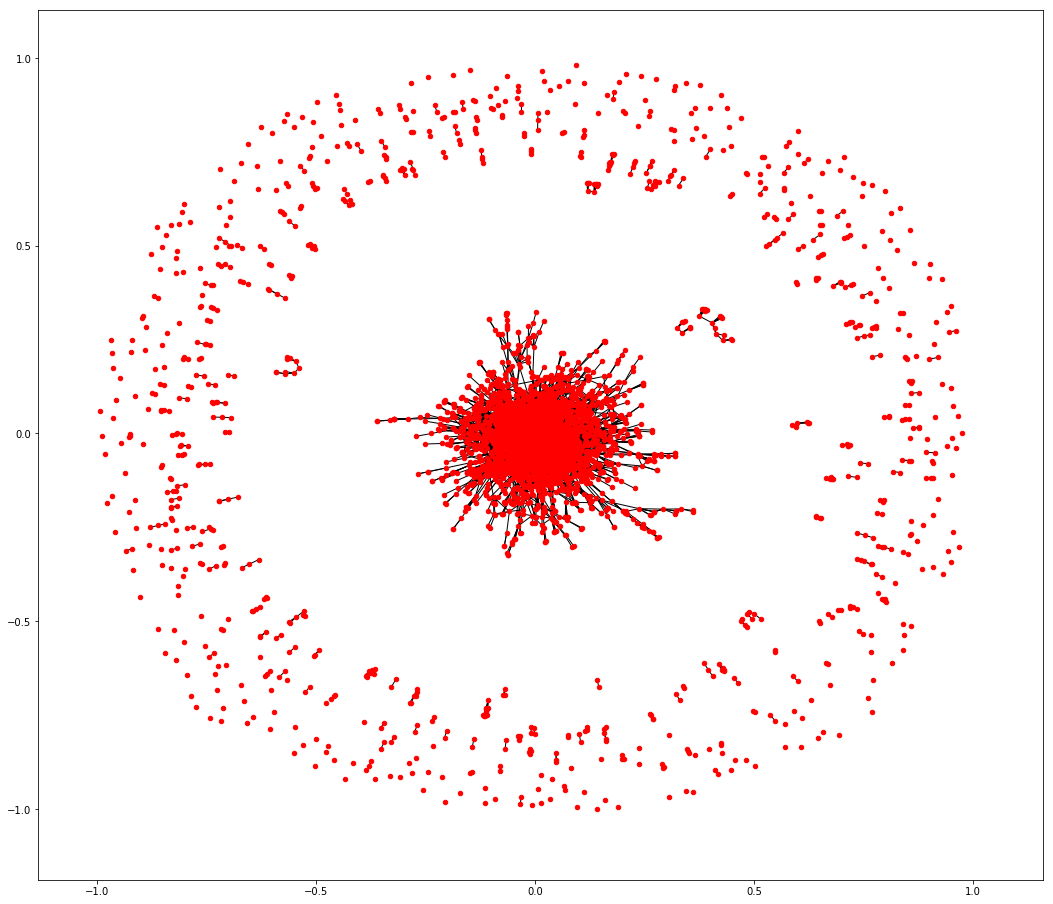

In [67]:
def draw_graph(G):
    plt.figure(figsize=(18, 16))
    nx.draw_networkx(G, node_size=20, with_labels=False)

draw_graph(G)

## 2. Distribución de Grado
Grafique la distribución del grado de los autores, en escalas lineales, semilogarıtmica, y log-log. Argumente, a partir de los graficos, de que tipo de distribucion se trata.

Gráfico de Distribución del Grado de los Autores en Escala Lineal

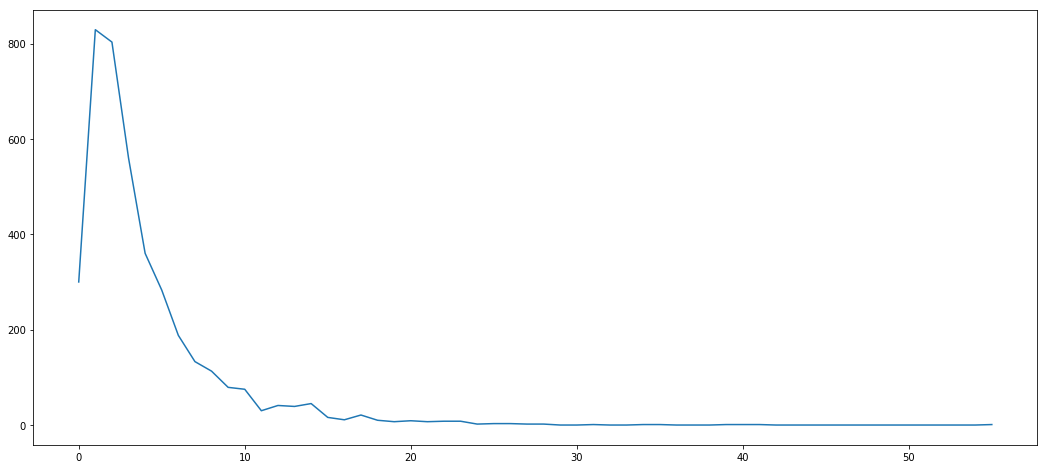

In [68]:
deg_histogram = nx.degree_histogram(G)
plt.plot(deg_histogram)

Mismo gráfico, pero en escala semi-log.

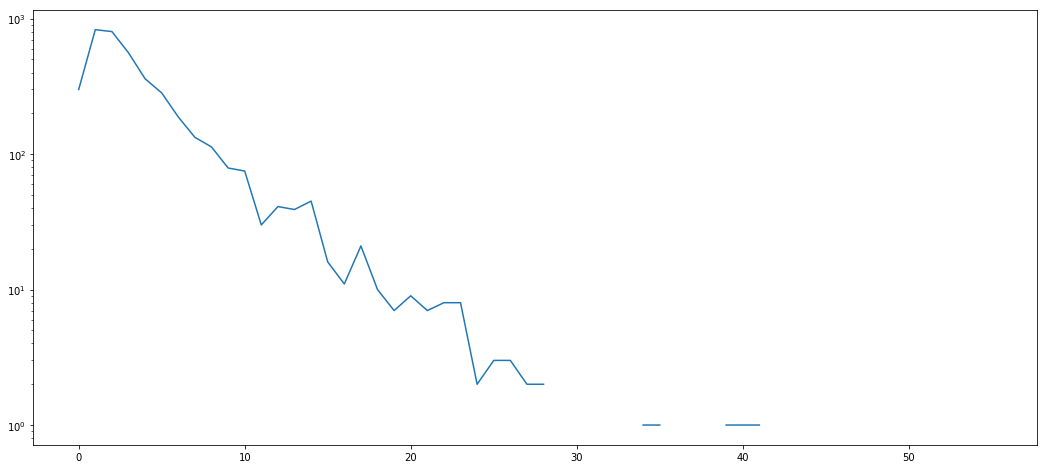

In [69]:
plt.semilogy(deg_histogram)

Mismo gráfico, pero en escala log-log.

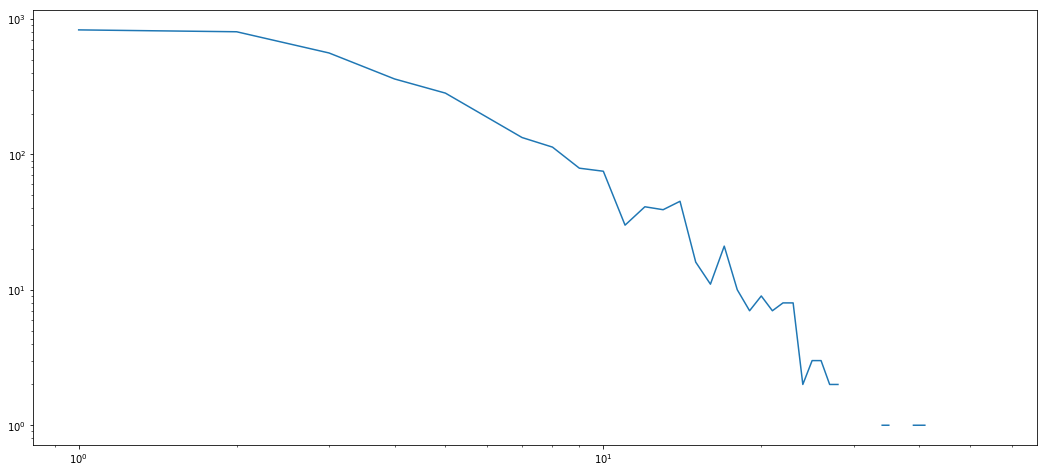

In [70]:
plt.loglog(deg_histogram)

Vista con el eje Y en escala logarítmica parece ser una línea recta, por lo que la distribución parecería ser una exponencial

## 3. Componentes Conexas
Calcule el número de componentes conexas del grafo. Muestre el tamaño de la componente mayor, o componente gigante.

In [71]:
amount_of_connected_components = nx.number_connected_components(G)
print('Cantidad de componentes conexas: {}'.format(amount_of_connected_components))

Cantidad de componentes conexas: 536


Buscamos la componente mayor para mostrar su tamaño.

In [72]:
connected_components = nx.connected_components(G)
biggest_connected_component = max(connected_components, key=len)
print("Tamaño de la componente mayor: {}".format(len(biggest_connected_component)))

Tamaño de la componente mayor: 3014


## 4.Tamaño de Vecindades
Trabajando con la componente gigante del grafo, estudie, parándose en un nodo al azar, cómo aumenta
el número de autores alcanzados a medida que se aleja del nodo semilla. Grafique el número de autores
alcanzados en función de la distancia al nodo semilla. Grafique también el número de nuevos autores
que se agregan en cada paso, y estime el máximo de esta función. Pruebe con varios nodos semillas y
analice la robustez de este resultado. Discuta el significado de los gráficos y su relación con el fenómeno
de seis grados de separación.

Generamos una función que nos da, para una componente, información de un nodo aleatorio almacenada en un diccionario de la forma {nodo: [distancia_a_source, cantidad_de_vecinos, set(vecinos)]} para él. Repetimos el proceso a medida que nos alejamos del nodo aleatorio, llendo por sus vecinos.

In [73]:
def generate_random_node_info_from_component(component):
    random_node = random.choice(list(component))  # Generamos el primer nodo aleatorio.
    neighbors_per_node = OrderedDict()
    succesors = nx.dfs_preorder_nodes(G, random_node)
    previous_distance = 0
    current_distance = 0
    for index, succesor in enumerate(succesors):
        previous_distance = current_distance
        current_distance = len(nx.shortest_path(G, succesor, random_node))
        if current_distance < previous_distance: break  # Termino cuando DFS recorrió toda la profundidad del grafo
        neighbors = nx.all_neighbors(G, succesor)  # Obtenemos vecinos del nodo.
        neighbors_set = set(neighbors)
        amount_of_neighbors = len(neighbors_set)
        # Generamos entrada de tipo nodo: [dist_a_source, cant_vecinos, vecinos]
        neighbors_per_node[succesor] =  [current_distance, amount_of_neighbors, neighbors_set]
    return random_node, neighbors_per_node

Generamos 2 funciones que nos dan los gráficos pedidos por el punto 4, para una componente y un nodo.

In [74]:
def generate_amount_of_neighbors_graphic(component, neighbors_per_node):
    # Generamos seed para un nodo aleatorio.
    amount_of_neighbors_ordered_by_scaling_distance = []
    # Info_node contiene, para un nodo: [dist_a_source, cant_vecinos, vecinos]
    for (node1, info_node1),(node2, info_node2) in pairwise(neighbors_per_node.items()):
        amount_of_neighbors_ordered_by_scaling_distance.append(info_node1[1])
    plt.plot(amount_of_neighbors_ordered_by_scaling_distance)
    
def generate_difference_between_added_neighbors_graphic(component, neighbors_per_node):
    # Generamos seed para un nodo aleatorio.
    difference_between_added_neighbors_ordered_by_scaling_distance = []
    # Info_node contiene, para un nodo: [dist_a_source, cant_vecinos, vecinos]
    for (node1, info_node1),(node2, info_node2) in pairwise(neighbors_per_node.items()):
        difference = len(info_node1[2] - info_node2[2])
        difference_between_added_neighbors_ordered_by_scaling_distance.append(difference)
    plt.plot(difference_between_added_neighbors_ordered_by_scaling_distance)
    return max(difference_between_added_neighbors_ordered_by_scaling_distance)
    


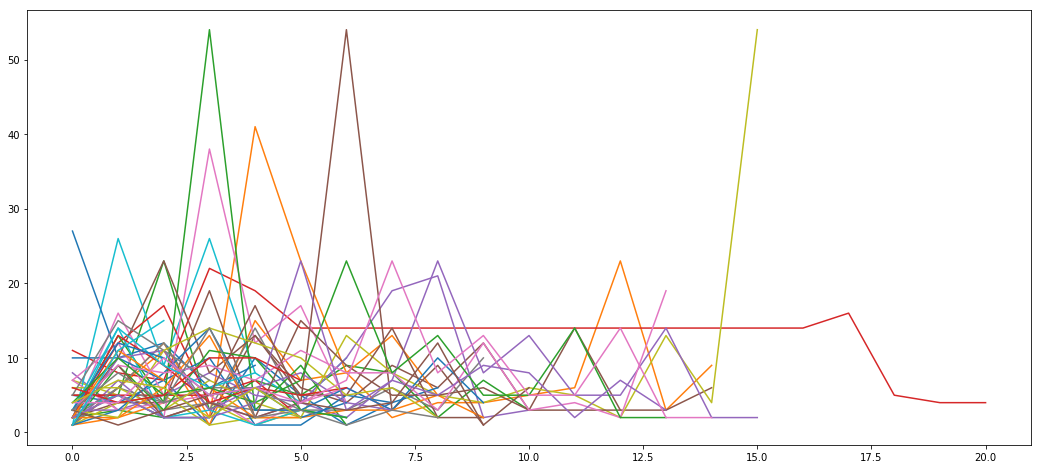

In [75]:
# Iteramos aleatoriamente 10 veces, guardando la informacion de los vecinos del nodo aleatorio en una lista.
# Luego, generamos el gráfico de cantidad de autores vs distancia.
neighbors_per_node_list = []
for i in range(50):
    random_node, neighbors_per_node = generate_random_node_info_from_component(biggest_connected_component)
    neighbors_per_node_list.append(neighbors_per_node)
for neighbors_per_node in neighbors_per_node_list:
    generate_amount_of_neighbors_graphic(biggest_connected_component, neighbors_per_node)

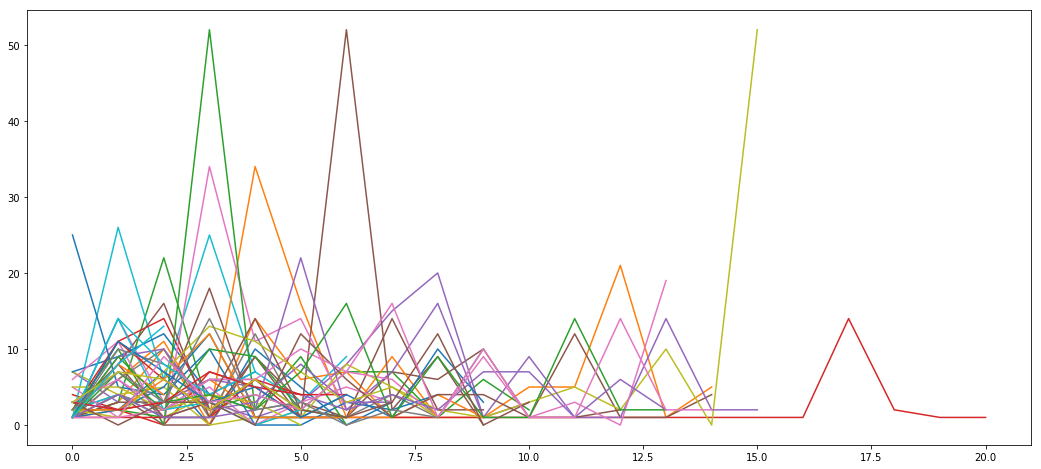

In [76]:
# Generamos el gráfico de diferencia de vecinos agregados vs distancia.
max_difference_per_random_node = []
for neighbors_per_node in neighbors_per_node_list:
    max_difference = generate_difference_between_added_neighbors_graphic(biggest_connected_component, neighbors_per_node)
    max_difference_per_random_node.append(max_difference)


El máximo de la función de número de nuevos autores que se agregan a cada paso es:

In [77]:
print(max(max_difference_per_random_node))

52


De éstos gráficos, podemos concluir varias características de la distribución. Primero, los autores tienen una cantidad fuertemente variable de co-autores en distintos libros (visible por la amplia diferencia de cantidad de vecinos entre nodos). Además, parecerían tener pocos autores en común, ya que el gráfico que marca la diferencia de autores agregados entre nodos resulta muy similar en cantidad al gráfico de cantidad de co-autores. Al ser tan constantemente grande la diferencia de co-autores, los resultados parecerían indicar que uno podría, desde un autor, alcanzar a otro en una pequeña cantidad de saltos.

Parecería haber una recta alrededor de y=25 que se alcanza independientemente del nodo de origen en menos de 8 saltos en promedio. Esto indicaría que, sin importar la cantidad de co-autores que tenga un autor, es posible alcanzar uno con alto grado (#co-autores) en 8 saltos o menos. 

TODO: calcular la media del maximo para cada nodo de partida

## 5. Mundos Pequeños

Compute el coeficiente de clustering C y el camino mínimo medio l para la componente gigante. Genere
un grafo aleatorio con la misma distribución de grado y compute las mismas medidas para este grafo.
Compare e interprete los resultados. ¿Se trata de un grafo con estructura de mundos pequeños?

Computamos coeficiente de clustering y camino mínimo medio para la componente gigante.

In [78]:
clustering_coef = nx.average_clustering(G, biggest_connected_component)
biggest_connected_component_subgraph = G.subgraph(biggest_connected_component)
# Generamos un archivo para la longitud de camino minimo medio, al ser costoso de calcular.
if not path.exists('biggest_connected_component_avg_shortest_path_length'):
    with open('biggest_connected_component_avg_shortest_path_length', 'wb') as f:
        pickle.dump(nx.average_shortest_path_length(biggest_connected_component_subgraph), f)
        
with open('biggest_connected_component_avg_shortest_path_length', 'rb') as f:
    avg_shortest_path_length = pickle.load(f)
print("Coeficiente de Clustering: {} , Longitud de Camino Minimo Medio: {}".format(clustering_coef, avg_shortest_path_length))

Coeficiente de Clustering: 0.48318448792867547 , Longitud de Camino Minimo Medio: 6.119058730460418


Generamos grafo aleatorio con la distribución de grado de la componente gigante. Luego, computamos las mismas métricas que para el grafo anterior.

In [79]:
deg_distribution = list([item[1] for item in nx.degree(biggest_connected_component_subgraph)])
random_graph = nx.configuration_model(deg_distribution, create_using=nx.Graph())
clustering_coef = nx.average_clustering(random_graph)
# Generamos la componente gigante para el grafo aleatorio, y luego un subgrafo de esta componente
random_graph_connected_components = nx.connected_components(random_graph)
random_graph_biggest_connected_component = max(random_graph_connected_components, key=len)
random_graph_biggest_connected_component_subgraph = random_graph.subgraph(random_graph_biggest_connected_component)
# Generamos un archivo para la longitud de camino minimo medio, al ser costoso de calcular.
if not path.exists('random_graph_avg_shortest_path_length'):
    with open('random_graph_avg_shortest_path_length', 'wb') as f:
        pickle.dump(nx.average_shortest_path_length(random_graph_biggest_connected_component_subgraph), f)
        
with open('random_graph_avg_shortest_path_length', 'rb') as f:
    avg_shortest_path_length = pickle.load(f)
    
print("Coeficiente de Clustering: {} , Longitud de Camino Minimo Medio: {}".format(clustering_coef, avg_shortest_path_length))

Coeficiente de Clustering: 0.0035688960909866533 , Longitud de Camino Minimo Medio: 4.739166340011348


TODO: se movio a la derecha en el gráfico de clustering vs longitud de camino medio

## 6.Estrellas

Discuta cómo haría para individuar a los autores “estrella” del campo. Evalúe quiénes son estos autores
según por lo menos dos métricas diferentes. Analice qué sucedería con la comunidad si estos autores
desapareciesen. En particular, determine cuántos autores deberían desaparecer para que desaparezca
la componente gigante del grafo.

In [86]:
def get_n_stars_with_centrality_criteria(n, graph):
    centrality_dict = nx.degree_centrality(G)
    centrality_dict_sorted = sorted([(v, k) for k,v in centrality_dict.items()], reverse=True)
    return centrality_dict_sorted[:n]

def get_n_stars_with_betweeness_centrality(n, graph):
    betweenness_dict = nx.betweenness_centrality(graph)
    betweenness_dict_sorted = sorted([(v, k) for k,v in betweenness_dict.items()], reverse=True)
    return betweenness_dict_sorted[:n]

get_n_stars_with_centrality_criteria(10, G)

[(0.013774104683195591, 'Lee'),
 (0.010267968945654895, 'Ambjorn'),
 (0.010017530678687703, 'Park'),
 (0.00976709241172051, 'Kim'),
 (0.00876533934385174, 'Ferrara'),
 (0.008514901076884547, 'Vafa'),
 (0.007763586275982969, 'Strominger'),
 (0.007012271475081391, 'Odintsov'),
 (0.007012271475081391, 'Gibbons'),
 (0.0067618332081141996, 'Pope')]

In [87]:
get_n_stars_with_betweeness_centrality(10, G)

[(0.043826937776947, 'Lee'),
 (0.028957042521455763, 'Kim'),
 (0.027376005887459975, 'Vafa'),
 (0.022283786626932815, 'Ambjorn'),
 (0.020909038482212306, 'Kogan'),
 (0.019346548778119258, 'Park'),
 (0.018946113041394687, 'Gibbons'),
 (0.018796107288657146, 'Li'),
 (0.018715301476627474, 'Ohta'),
 (0.01841252751598721, 'Ivanov')]

In [89]:
# TODO: Hacer Girvan-Newmann para el resto.
    # mirar la parte de itertools.takewhile() y pasarle la componente conexa mas grande, 
    # y que pare cuando esa se parte (osea cuando k = # comunidades>1)
    